<a href="https://colab.research.google.com/github/cullena20/RedditSentimentWebsite/blob/main/RedditSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reddit Sentiment Analysis!

In [1]:
from IPython import display  # control displaying of printed output in loops
from pprint import pprint  # pretty print json and lists
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
!pip install praw
import praw

     |████████████████████████████████| 153kB 4.8MB/s 
     |████████████████████████████████| 204kB 8.1MB/s 


In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## Exploring the Reddit API using PRAW

Access the Reddit API. This allows you to easilly acess data from Reddit. To do this go to https://www.reddit.com/prefs/apps/.

In [3]:
reddit = praw.Reddit(client_id='<your client_id>',
                     client_secret='<your client_secret>',
                     user_agent='<your user_agent>',
                     username='<your user_name')

In [20]:
# subreddit1 = reddit.subreddits.search_by_name('datascience', exact=True)  returns a list of search results
subreddit_name = 'datascience'
subreddit = reddit.subreddit(subreddit_name)
print("Display Name:")
print(subreddit.display_name) 
print()
print("Title:")
print(subreddit.title)   
print()
print("Description")      
print(subreddit.description) 

Display Name:
datascience

Title:
Data Science

Description



In [5]:
posts = set()  # use a set to clear any duplicates
for post in subreddit.new(limit=None):
  posts.add(post)
  display.clear_output()  # only one output that changes
  print(len(posts))
posts = list(posts)  # easier to work with lists

730


In [6]:
post = posts[2]
print(post.title)
print(post.author)
print(post.score)
print(post.id)
print(post.url)

I'm bored of hearing about ML and about the DS career path.
guinea_fowler
52
jwa241
https://www.reddit.com/r/datascience/comments/jwa241/im_bored_of_hearing_about_ml_and_about_the_ds/


Using the Reddit API, we can also explore comments. Maybe we can make a model that looks at comments as well as titles?

In [7]:
# this creates a list of comments from the post we already defined
comments = list(post.comments)
# pprint(vars(comments[1]))  # gives us variables for comment
print('Post Title:', post.title)
print()
print('Comment: ', comments[1].body)
print()
print('Comment Author: ', comments[1].author)
print('Score: ', comments[1].score)  # would be nice to have model weigh this too

Post Title: I'm bored of hearing about ML and about the DS career path.

Comment:  I'm currently doing causal analysis to determine the root drivers of sexual violence in a particular developing country. So identifying differing factors such as education, wealth status, assets, density of population in living area etc. Have stratified sample data to represent the entire population of the country. 

fyi Social Science work

Comment Author:  stingFC
Score:  17


## Basic Sentiment Analysis Using Pretrained Models


For now, we will explore various pretrained models that detect negative and positive sentiment. Alternativley, we could train our own model using a dataset and sklearn. However, these pretrained models actually perform pretty well.

The main model that we are using is vader from nltk. This model has been pretrained specifically for social media text. A detailed paper describing the model can be found at https://www.researchgate.net/publication/275828927_VADER_A_Parsimonious_Rule-based_Model_for_Sentiment_Analysis_of_Social_Media_Text.

Code for other models is commented out because we are not using them. You can uncomment to explore them though.

In [8]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()
# from textblob import TextBlob
# !pip install flair
# import flair
# flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [9]:
sentence = "This food was great but the service was only okay"
print("NLTK VADER")
print(sia.polarity_scores(sentence))
# print()
# print("Text Blob:")
# print(TextBlob(sentence).sentiment)
# print()
# print("Flair:")
# s = flair.data.Sentence(sentence)
# flair_sentiment.predict(s)
# total_sentiment = s.labels
# print(total_sentiment)

NLTK VADER
{'neg': 0.0, 'neu': 0.62, 'pos': 0.38, 'compound': 0.5994}


In [10]:
results = list()

for post in posts:
    pol_score = sia.polarity_scores(post.title)
    pol_score['headline'] = post.title
    results.append(pol_score)

pprint(results[:3], width=100)  # pretty print

[{'compound': -0.5574,
  'headline': 'Seriously, how am I expected to grow in a profession where everyone discourages me '
              'from building anything non-trivial',
  'neg': 0.247,
  'neu': 0.753,
  'pos': 0.0},
 {'compound': 0.0,
  'headline': 'DS professional looking for guidance to build out NLP skillset',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': -0.2732,
  'headline': "I'm bored of hearing about ML and about the DS career path.",
  'neg': 0.16,
  'neu': 0.84,
  'pos': 0.0}]


Now we will store the data as a pandas dataframe. We will create a new column, 'label', that will store if the headline is positive (1), neutral (0), or negative (-1). We have used 0.2 and -0.2 as our thresholds but this can be altered (giving us different results).

In [17]:
df = pd.DataFrame.from_records(results)
sorted_df = df.sort_values(by='compound')
df['label'] = 0  # creates label column
df.loc[df['compound'] > 0.2, 'label'] = 1  # if compound score is greater than 0.2 we label it as positive
df.loc[df['compound'] < -0.2, 'label'] = -1  # if compound score is less than -0.2 we label it as positive
df.sample(n=10,axis='rows')  # prints 10 random items from the dataframe

,neg,neu,pos,compound,headline,label
366,0.0,1.000,0.000,0.0000,Does anyone here use orange 3?,0
48,0.0,0.784,0.216,0.0258,Do the course certificates matter?,0
714,0.0,0.940,0.060,0.4019,I am a junior data analyst with an Econ backgr...,1
377,0.0,1.000,0.000,0.0000,What is your take on job postings that ask for...,0
309,0.0,1.000,0.000,0.0000,Using Decision Trees to Find Business Rules - ...,0
267,0.0,0.903,0.097,0.4404,I'm in the market for a laptop. As a data anal...,1
305,0.0,0.700,0.300,0.4588,"Do people have luck using ""modern"" resume temp...",1
530,0.0,1.000,0.000,0.0000,Non-Negotiable salary Offer for a Lead Analyst...,0
510,0.0,0.649,0.351,0.4019,Data science relate christmas holiday puns,1
705,0.0,1.000,0.000,0.0000,Data science career path?,0


Now that we have our results, we can save them in a csv file!

In [23]:
df.to_csv('{}_sentiment'.format(subreddit_name))

The below code clearly shows the analysis of a subreddit.

In [22]:
percentages = df.label.value_counts(normalize=True) * 100
for key in percentages.keys():
    if key == -1:
        percentages['Negative'] = percentages[key]
        del percentages[key]
    if key == 0:
        percentages['Neutral'] = percentages[key]
        del percentages[key]
    if key == 1:
        percentages['Positive'] = percentages[key]
        del percentages[key]
print(percentages)

Neutral     61.095890
Positive    28.082192
Negative    10.821918
Name: label, dtype: float64


## Exploring Our Results

We can explore the most positive and negative headlines using the below code.

In [13]:
sorted_df = df.sort_values(by='compound')
print('Five Most Positive Titles:')
for headline in list(sorted_df.tail(5)['headline']):
  print(headline)
print()
print('Five Most Negative Titles:')
for headline in list(sorted_df.head(5)['headline']):
  print(headline)


Five Most Positive Titles:
Best resource to learn Excel for data science?
As a data scientist, what action should be taken to have the greatest positive impact on society and the environment?
Why do you love / hate about the Data Science field ? And how it compare to Software Engineering. I'm very appreciated about your sharing. Thank you very much.
After spending more than a year as a data scientist I found these 4 hard truths data science blogs don't teach you about. I hope sharing my journey helps you in some way.
A whole year from now to start applying to DS jobs. I'm in a good situation. I can choose what skills to improve, and I'm sure your advice will be super helpful.

Five Most Negative Titles:
What was your most WTF analysis or insight obtained?
Angry rant
Did anyone regret choosing DS as a career or has got disillusioned with it?
Unusual question but: does your data science experience make you more aware of congnitive traps that some people fall into when believing conspirac

This code will print the first five negative results and the first five positive results. These do not take into account how positive or negative that they are.

In [14]:
positive_results = df[df['label'] == 1]
negative_results = df[df['label'] == -1]
print("Postitive Results:")
pprint(list(positive_results['headline'])[:5]) 
print()
print("Negative Results:")
pprint(list(negative_results['headline'])[:5]) 

Postitive Results:
['Best DS setup within company firewall/proxy',
 'Dear Data scientists on this forum at Twitter & Facebook - please do '
 'something at your companies',
 'Would anyone be interested in a “soft data science” series?',
 'How to go about creating models without labels',
 'Data Engineer, watching upper management contract out work that I feel that '
 "I'm capable of doing"]

Negative Results:
['Seriously, how am I expected to grow in a profession where everyone '
 'discourages me from building anything non-trivial',
 "I'm bored of hearing about ML and about the DS career path.",
 'How do we stop AI or machine learning algorithms from being “racist sexist '
 'xenophobic” etc',
 'Is putting data camp certificates on linkedin obnoxious?',
 'Averaging margin of errors of polls']


Now we can determine the overall sentiment of a subreddit by creating percentages of positive, neutral, and negative headlines.

In [15]:
percentages = df.label.value_counts(normalize=True) * 100
print("Count:")
print(df.label.value_counts())
print()
print("Percentages:")
print(percentages)

Count:
 0    446
 1    205
-1     79
Name: label, dtype: int64

Percentages:
 0    61.095890
 1    28.082192
-1    10.821918
Name: label, dtype: float64


The below code lets us visualize the above results.

[]

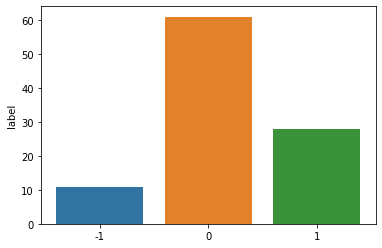

In [16]:
sns.barplot(x=percentages.index, y=percentages)
plt.xlabel = ['Negative', 'Nuetral', 'Positive']
plt.plot()

## Future Model Improvement

We classified a subreddit's sentiment soley based on the titles of its top posts. Maybe we can look at more data such as comments and upvotes. Using this same idea, we may also be able to make a more practical model, such as a fake news or hate speech detector. This would involve using different models and potentially needing training data.

## Now What?

In this notebook, we have explored the Reddit API, and different sentiment analysis models. We have also been able to visualize our results. Using these ideas and the code as a foundation, we can turn this into something more accesible. For example, we can make a website where a user types in a subreddit and get a sentiment analysis back. We can make a cli to
 analyze subreddits in the command line.